# Initial look at clustering for Asteroid tracklets:
### Asteroid tracklets CS 182 project: Paul Blankley, Ryan Janssen, Matthew Holman

**Potentially useful docs / sources:**

Blog: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/#Inconsistency-Method

Cophenet: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.cophenet.html

Linkage: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage

Inconsistent: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.inconsistent.html

Fcluster: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html



In [26]:
# Imports
from time import time
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.colors as mlc
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import inconsistent
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from statsmodels import robust
import numpy as np
from collections import defaultdict

%matplotlib inline

In [2]:
with open('../ITF/test_r2.5_rd0.out','r') as file:
    lines = file.read().split('\n')
    r2p5 = [i.split() for i in lines[:-1]]
    mxs = np.array([float(i[1]) for i in r2p5])
    cxs = np.array([float(i[2]) for i in r2p5])
    mys = np.array([float(i[3]) for i in r2p5])
    cys = np.array([float(i[4]) for i in r2p5])
    

### Distribution of columns

In the analysis below I plot the distributions of each column and present the medians and median absolute deviation of each column.  I chose the median and MAD because we have no guarantee the data is normally distributed, and median / MAD is more robust to outliers than mean / std (income example).

Median of normalized mxs:                    0.835707458893
Median absolute deviation of normalized mxs: 0.000454745966819
Median of normalized cxs:                    0.810148405924
Median absolute deviation of normalized cxs: 0.00378255946278
Median of normalized mys:                    0.0256137801351
Median absolute deviation of normalized mys: 0.000856024992634
Median of normalized cys:                    0.0114970936422
Median absolute deviation of normalized cys: 0.00275093513606


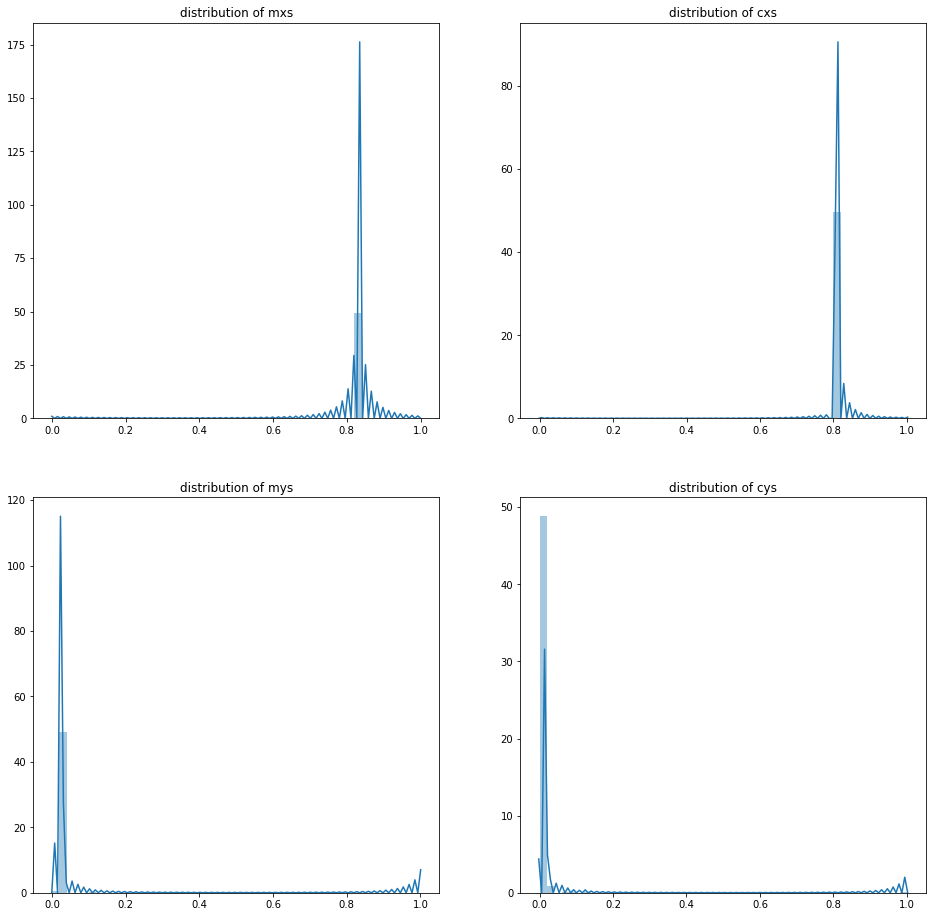

In [34]:
# Plots of distributions of the inconsistency clusters
fig,([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2,figsize=(16,16))

normalized_cols = []
for col in [mxs,cxs,mys,cys]:
    scale_col = MinMaxScaler().fit(col.reshape(-1,1))
    normalized_cols.append(scale_col.transform(col.reshape(-1,1)))

for name,col in zip(['mxs','cxs','mys','cys'],normalized_cols):
    print('Median of normalized %s:                   '%name,np.median(col))
    print('Median absolute deviation of normalized %s:'%name,robust.mad(col)[0])

sns.distplot(normalized_cols[0],ax=ax1)
ax1.set_title('distribution of mxs')

sns.distplot(normalized_cols[1],ax=ax2)
ax2.set_title('distribution of cxs')

sns.distplot(normalized_cols[2],ax=ax3)
ax3.set_title('distribution of mys')

sns.distplot(normalized_cols[3],ax=ax4)
ax4.set_title('distribution of cys')

### Dendrograms and linkage
The below dendrogram shows the higher level clustering of the hierarchical model.  For a good tutorial and more reading on this type of clustering check this out: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

NOTE: This is the high level clustering, we are interested in the low level where the tracklets are very close to each other. Also, when we refer to "link height" in later sections, we refer to the height (using our distance metric) of the links between the clusters in the dendrogram below.  The taller the links the bigger the jump the cluster must make to form a new cluster.  We also calculate the linkage matrix in this step.  The linkage matrix has (n-1) rows and 4 columns.  The first two columns are the indices of the points or the cluster id's of the points or clusters being joined.  The third columnn is the (user specified metric) distance between the the two clusters or points.  The fourth column is the number of points in the cluster. Docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

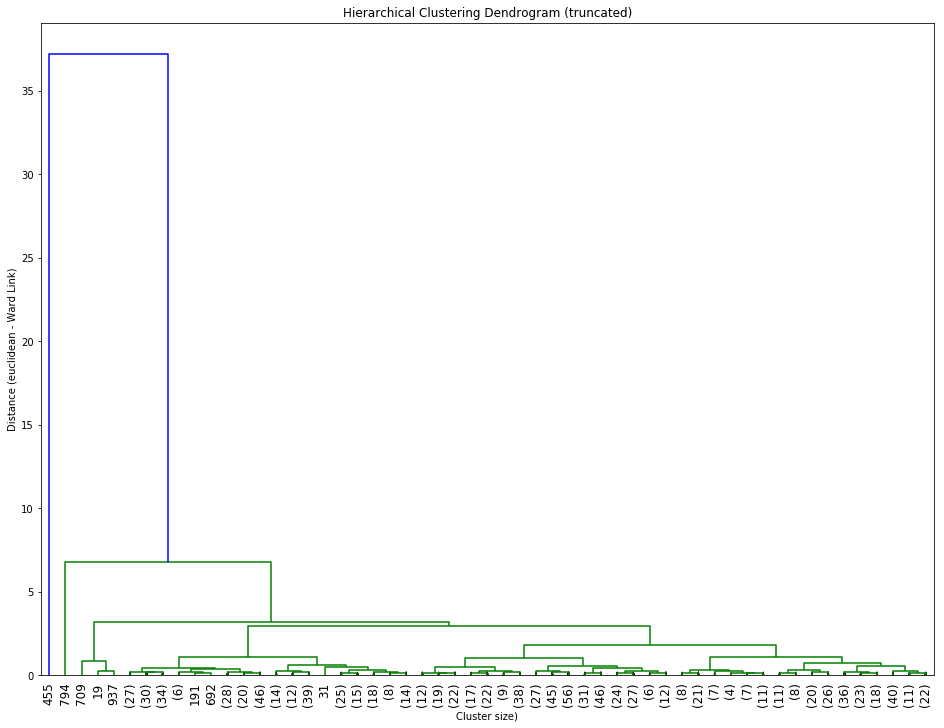

In [3]:
# Convert the array to a numpy array
numeric_vals = np.array([mxs, cxs, mys, cys]).T

# Make linkage
Z = linkage(numeric_vals, 'ward')

# Dendogram
fig,ax = plt.subplots(figsize=(16,12))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Cluster size)')
plt.ylabel('Distance (euclidean - Ward Link)')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=55,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

### Cophenetic distance and correlation
The correlation coefficient below compares the accuracy of the dendrogram distance (the link height) with the actual pairwise distances in the original matrix to see how well the dendrogram preserves pairwise distance.  The closer the number is to 1.0 the better. Check out this link for further reading: https://en.wikipedia.org/wiki/Cophenetic_correlation

The Cophenetic distance is the measure the $t$ (threshold) variable represents in the fcluster clustering method under the max_distance paradigm, but *not* the inconsistent paradigm.  If a cluster node and all its descendants have an inconsistent value less than or equal to $t$ (threshold) then all its leaf descendants belong to the same cluster. When no non-singleton cluster meets this criterion, every node is assigned to its own cluster.

Cophenetic correlation coefficient: 0.854568379056
Avg Cophenetic distance: 2.02351879883


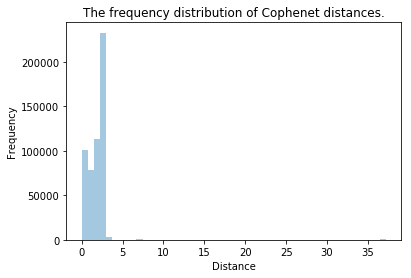

In [4]:
# Cophenetic distance analysis
c_cor, coph_dists = cophenet(Z,pdist(numeric_vals))
print('Cophenetic correlation coefficient:',c_cor)
print('Avg Cophenetic distance:',coph_dists.mean())

# Distribution plot
sns.distplot(coph_dists,kde=False)
plt.title('The frequency distribution of Cophenet distances.')
plt.xlabel('Distance')
plt.ylabel('Frequency')

### Clustering with Euclidean distance (Ward Linkage)
Here are the clusters.  This plot shows the clustering by color (the color is randomized, so there is no real pattern yet the possibility still exists that similar colors will be next to different classes). I think we can see some pretty good behavior initially from the clusters.  They look pretty tight and seem to be seperating the data in a meaningful way.  

The method I (Paul) thinks looks most promising is the distance method.  This method works by specifying a cophenetic distance threshold, $t$, above which we will not cluster any points.  This means that we will cluster points that are close to each other (by this distance metric) while ignoring points that are far away from each other by the cophenetic distance metric.  These ignored points will be clustered as singletons if they are not close enough to any other point.  

In the below analysis, there is one hyperparameter to tune.  This is the cophenetic distance metric mentioned above.  Setting this distance to a very high level will result in a few very large clusters, while setting it very small will result in a lot of singletons and a few very close clusters.  The key to tuning it will be to find the happy medium where we have tight, meaningful clusters but not clusters that contain unrelated points.  

To present a more meaningful visualization, we drop the singleton clusters from the plot and from the resulting dictionary that has the cluster id as its key and the related tracklet id's as its values. We can assign the labels to the clusters because we know the output of the `fcluster` method is going to be in order of the original data. 

Docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html


We found 280 different clusters of tracklets.
The average cluster size is 2.493
We clustered 698 tracklet ids.
Largest cluster: 6


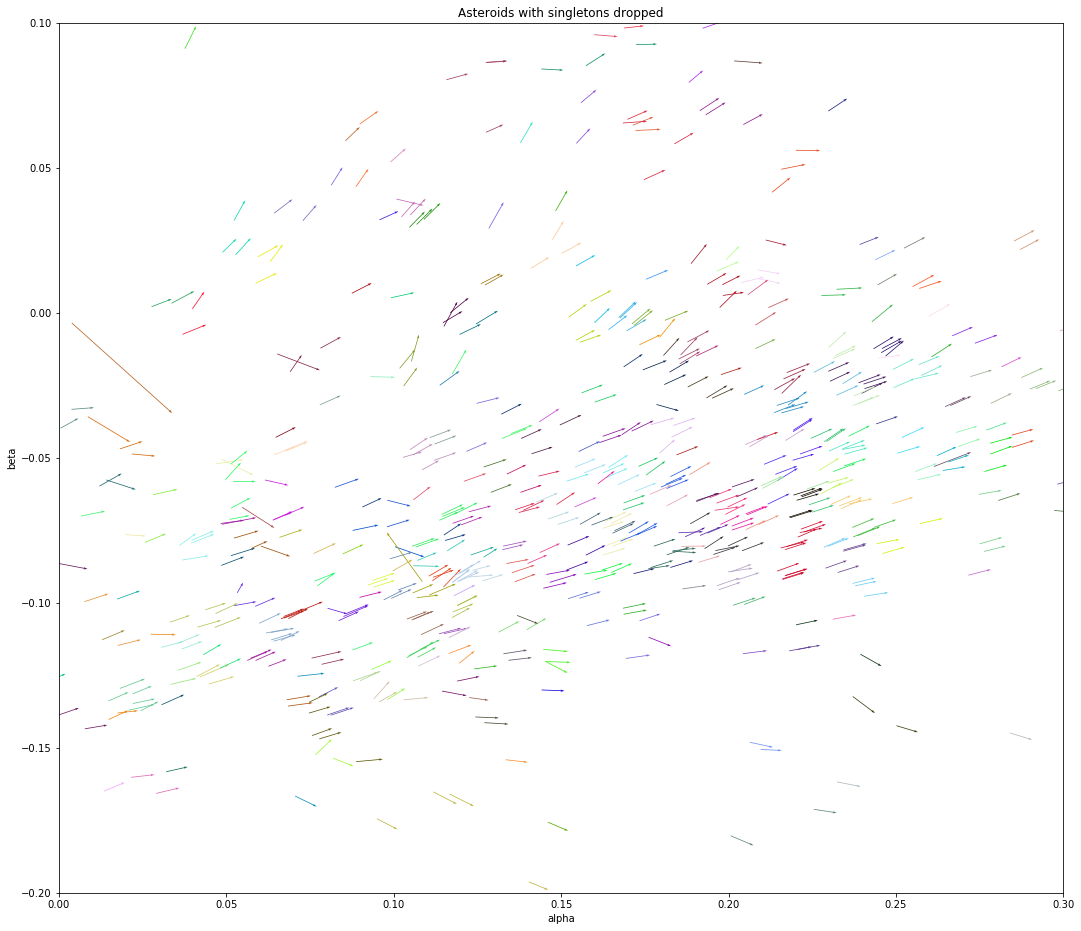

In [5]:
# Cluster with a max distance 

# THIS IS THE HYPERPARAMETER TO TUNE
####################################
                                   #
max_d = 0.005                      #
                                   #
####################################

# Perform the clustering (approx O(n^2))
clusters_md = fcluster(Z, t=max_d, criterion='distance')

# Create the labels vector
labels = [i[0] for i in r2p5]

# Create a dict with the cluster id as the key and the associated tracklet id's as the values
clusters_with_tags = defaultdict(list)
for i, itm in enumerate(clusters_md):
    clusters_with_tags[itm].append(labels[i])

# Create a mask that filters out all singlton clusters
msk = np.ones(len(clusters_md),dtype=bool)
for k,v in clusters_with_tags.items():
    if len(v)==1:
        msk[k]=False
        
# Drop all singletons from the original dictionary
for k,val in enumerate(msk):
    if not val:
        clusters_with_tags.pop(k)

# Summary of results in text
n_obs = [len(v) for k,v in clusters_with_tags.items()]
print('We found {} different clusters of tracklets.'.format(len(clusters_with_tags.keys())))
print('The average cluster size is {0:.3f}'.format(np.mean(n_obs)))
print('We clustered {} tracklet ids.'.format(np.sum(n_obs)))
print('Largest cluster:',max(n_obs))

# Asteroid plot with dropped
fig=plt.figure(figsize=(18, 16))
cm = mlc.ListedColormap ( np.random.rand ( 256,3))
plt.quiver(cxs[msk], cys[msk], mxs[msk], mys[msk], clusters_md[msk], cmap=cm,scale=0.2, width=0.00075)
plt.xlim(-0.0, 0.3)
plt.ylim(-0.2, 0.1)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Asteroids with singletons dropped')
plt.show()


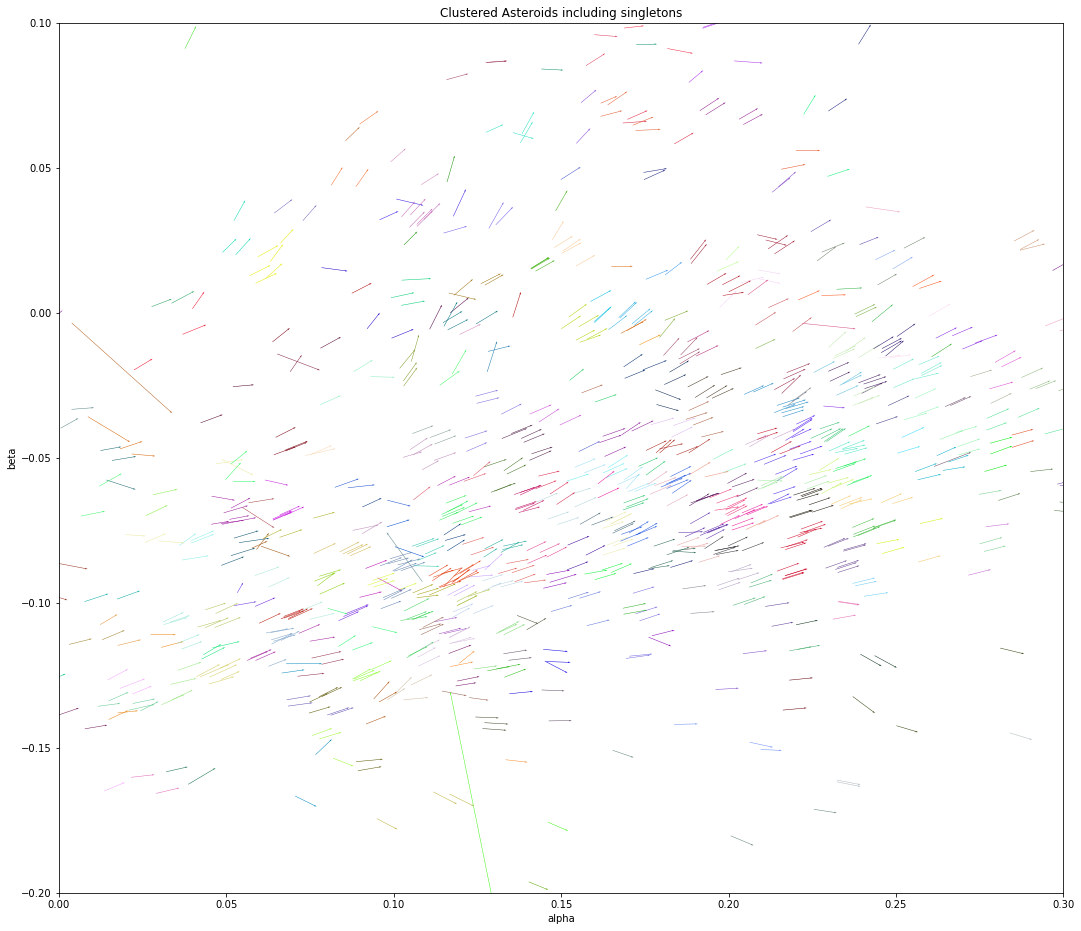

In [6]:
# Full asteroid plot with classifications
fig=plt.figure(figsize=(18, 16))
plt.quiver(cxs, cys, mxs, mys, clusters_md, cmap=cm,scale=0.2, width=0.0005)
plt.xlim(-0.0, 0.3)
plt.ylim(-0.2, 0.1)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Clustered Asteroids including singletons')

In [35]:
#####################################################
# NOW LETS LOOK AT NORMALIZED DATA
#####################################################

Now I use the normalized data, and I added a way to weight the columns however you would like.  I think this is a good tool, but I will need to have Matt look at the tuning for the weights to come up with a good first-principles tuning strategy.

We found 251 different clusters of tracklets (normalized).
The average cluster size is 2.406 (normalized)
We clustered 604 tracklet ids (normalized).
Largest cluster (normalized): 6


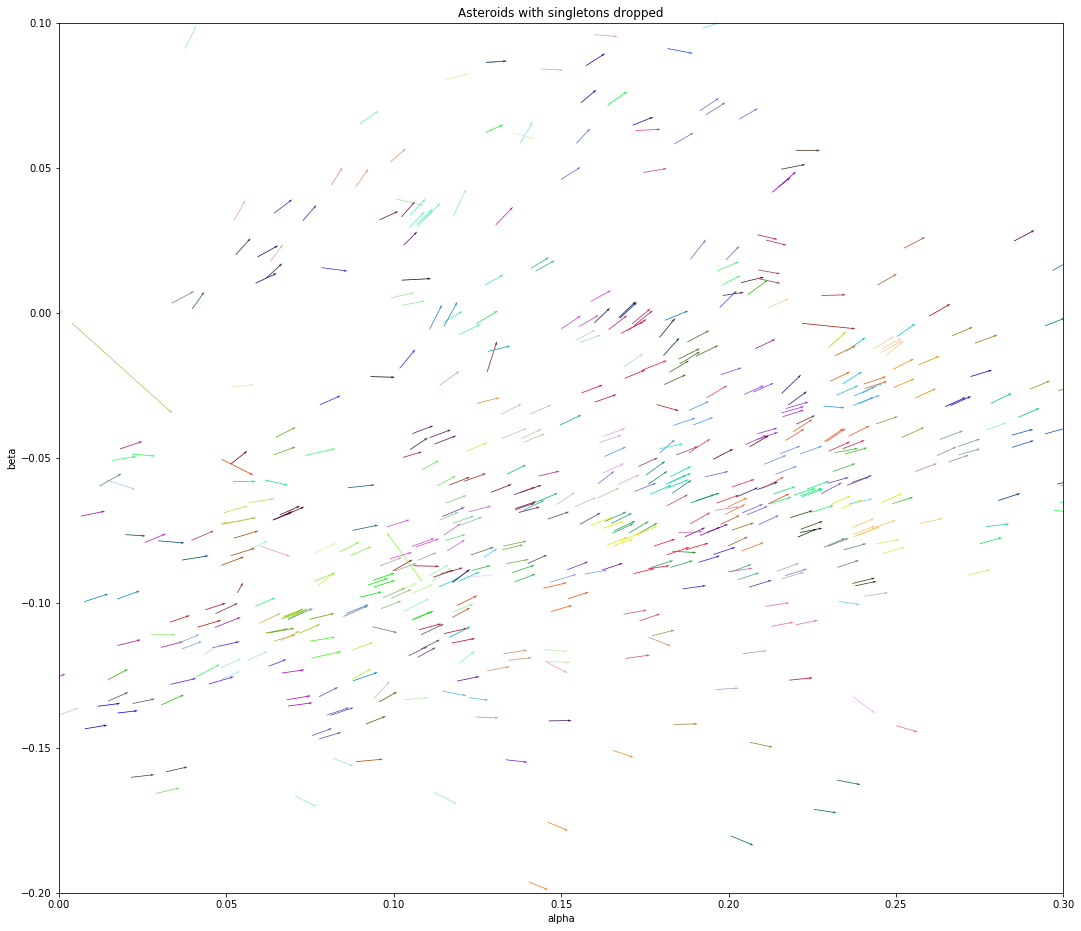

In [68]:
norm_cols = np.array(normalized_cols).T[0]

# Cluster with a max distance 

# THIS IS THE HYPERPARAMETER TO TUNE
####################################
                                   #
max_d_norm = 0.0007                 
weights = [1.,1.5,1.,1.5]                             
                                   #
####################################

# Perform the linkage 
Z_norm = linkage(norm_cols*weights, 'ward') # takes O(n^2) time

# Perform the clustering (approx O(n^2))
clusters_norm = fcluster(Z_norm, t=max_d_norm, criterion='distance')

# Create the labels vector (same as not normalized)
labels = [i[0] for i in r2p5]

# Create a dict with the cluster id as the key and the associated tracklet id's as the values
clusters_with_tags_norm = defaultdict(list)
for i, itm in enumerate(clusters_norm):
    clusters_with_tags_norm[itm].append(labels[i])

# Create a mask that filters out all singlton clusters
msk_norm = np.ones(len(clusters_norm),dtype=bool)
for k,v in clusters_with_tags_norm.items():
    if len(v)==1:
        msk_norm[k]=False
        
# Drop all singletons from the original dictionary
for k,val in enumerate(msk_norm):
    if not val:
        clusters_with_tags_norm.pop(k)

# Summary of results in text
n_obs_norm = [len(v) for k,v in clusters_with_tags_norm.items()]
print('We found {} different clusters of tracklets (normalized).'.format(len(clusters_with_tags_norm.keys())))
print('The average cluster size is {0:.3f} (normalized)'.format(np.mean(n_obs_norm)))
print('We clustered {} tracklet ids (normalized).'.format(np.sum(n_obs_norm)))
print('Largest cluster (normalized):',max(n_obs_norm))

# Asteroid plot with dropped
fig=plt.figure(figsize=(18, 16))
plt.quiver(cxs[msk_norm], cys[msk_norm], mxs[msk_norm], mys[msk_norm], \
                                                       clusters_norm[msk_norm],cmap=cm,scale=0.2, width=0.00075)
plt.xlim(-0.0, 0.3)
plt.ylim(-0.2, 0.1)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Asteroids with singletons dropped')
plt.show()


In [7]:
######################################################
# All the below is inconsistency related analysis.
######################################################

Inconsistency is the first unsupervised method we decided to apply to this problem.  Inconsistency has two hyperparameters.  The first is the `depth` value.  This value tells the algorithm what depth to stop searching as it goes up the tree.  The next is the `threshold` (our `i_cut` variable) value which we use to specify the inconsistency value above which we will not cluster any points, and below which we say the elements we clustered belong in a cluster together. 

Note: Value, that is `clusters_i[j]`, in `clusters_i` is the key of the cluster the point j belongs to, whereas the output from inconsistent at `incon[j]` relates to the jth *cluster* not the jth point in the original data. Thus, the index of `incon` is directly related to the value of `clusters_i`.

In [61]:
## The code below was used for the inconsist method of fitting.

# Cluster using inconsistency metric 
# dist_bet = 1.1 # seems to control the proximity of vectors we allow to cluster
# incon = inconsistent(Z,20)
# clusters_i = fcluster(Z, dist_bet, criterion='inconsistent', depth=20)

# Drop clusters that don't meet a certain cutoff for the inconsistency metric (col 4 of the incon output)
# sns.distplot(incon[:,3])
# plt.title('Distribution of the inconsistency metric.')
# plt.show()
# for i in range(len(incon)):
#     t = incon[i,3]>cutoff
#     if t:
#         if i in clusters_i:
#             for j,itm in enumerate(clusters_i):
#                 if itm==i:
#                     clusters_i[j] = -1

# Create the labels vector
# labels = [i[0] for i in r2p5]

# # Create a dict with the cluster id as the key and the associated tracklet id's as the values
# clusters_with_tags = defaultdict(list)
# for i, itm in enumerate(clusters_i):
#     clusters_with_tags[itm].append(labels[i])

    
# num_obs_in_clusters = [len(val) for k, val in clusters_with_tags.items() if k !=-1]

# print('We found {} different clusters of tracklets.'.format(len(clusters_with_tags.keys())-1))
# print('The average cluster size is {0:.3f}'.format(np.mean(num_obs_in_clusters)))
# print('We clustered {} tracklet ids.'.format(np.sum(num_obs_in_clusters)))
# print('Largest cluster:',max(num_obs_in_clusters))

# Plots of distributions of the inconsistency clusters
# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
# sns.distplot(incon[:,0],ax=ax1)
# ax1.set_title('distribution of means')

# # sns.distplot(np.log(incon[:,0]),ax=ax2)
# # ax2.set_title('log distribution of means')

# sns.distplot(incon[:,3],ax=ax2)
# ax2.set_title('distribution of inconsistency metrics (standardized linkage)')

# # sns.distplot(incon[:,2],ax=ax4)
# # ax4.set_title('distribution of the number of links in the calculation')